In [60]:
import warnings
from importlib import reload
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm, trange
from joblib import delayed

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import poison, random_synthesis, poison_secml
from libutil import ProgressParallel
from libdatasets import *

In [6]:
reload(libactive); reload(libadversarial)

<module 'libadversarial' from 'C:\\Users\\Zac\\Programming\\python\\research\\libadversarial.py'>

2020-12-18 14:13:05,672 - py.warnings - WARNING - c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



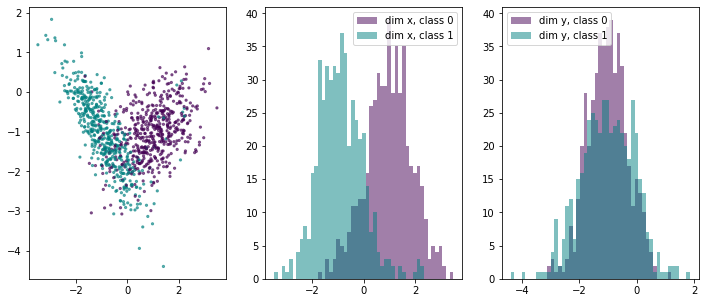

In [13]:
X, y = generateData_twoPills_2D(1000)
plot_dataset_2D(X, y)

In [14]:
# Use a model trained on all data as the Oracle. I'm not certain this makes sense, but I can't think of a better way right now
oracle = svm.SVC(kernel='linear')
oracle.fit(X, y);

In [15]:
X_train, X_validate, Y_train, Y_validate, X_test, Y_test = active_split(
        X, y, test_size=0.5, labeled_size=0.05, shuffle=True
    )

In [16]:
def stopping_func(learner, metrics):
    return metrics['accuracy_score'] >= 0.98 or learner.X_training.shape[0] > 1000

In [42]:
#reload(libactive); from libactive import MyActiveLearner
learner = MyActiveLearner(animate=True)
random_metrics = learner.active_learn_query_synthesis(
    X_train, 
    Y_train, 
    lambda x: oracle.predict(x), 
    X_test, 
    Y_test, 
    partial(random_synthesis, n_instances=10, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]), 
    stopping_func
)

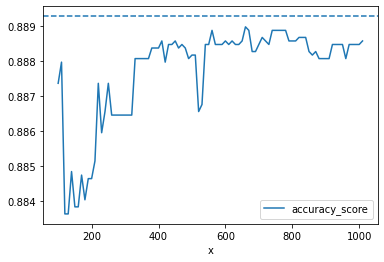

In [50]:
ax = random_metrics.frame.plot(0, 1)
ax.axhline(metrics.accuracy_score(Y_test, oracle.predict(X_test)), ls='--')

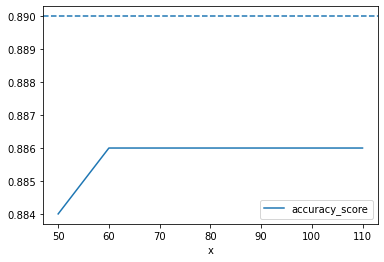

In [28]:
ax = poison_metrics.frame.plot(0, 1)
ax.axhline(metrics.accuracy_score(Y_test, oracle.predict(X_test)), ls='--')

## Biased

In [46]:
def stopping_func(learner, metrics):
    return metrics['accuracy_score'] >= 0.98 or learner.X_training.shape[0] > 1000

In [47]:
X_biased, y_biased = Bias.bias_rotate_2D(X_train, Y_train, alpha=np.pi, biasedClass=0, prob=0)

In [33]:
reload(libadversarial); reload(libactive); from libactive import MyActiveLearner; from libadversarial import poison
learner = MyActiveLearner(animate=True)
poison_metrics = learner.active_learn_query_synthesis(
    X_biased, 
    y_biased, 
    lambda x: oracle.predict(x), 
    X_test, 
    Y_test, 
    partial(poison, n_instances=10, clip_values=[np.amin(X), np.amax(X)]), 
    stopping_func,
)

Random synthesis (biased initial data)

In [38]:
reload(libactive); from libactive import MyActiveLearner
reload(libadversarial); from libadversarial import random_synthesis
learner = MyActiveLearner(animate=True)
random_metrics = learner.active_learn_query_synthesis(
    X_biased, 
    y_biased, 
    lambda x: oracle.predict(x), 
    X_test, 
    Y_test, 
    partial(random_synthesis, n_instances=10, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]), 
    stopping_func
)

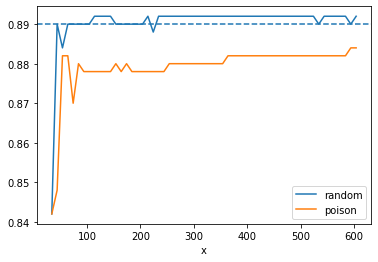

In [42]:
ax = random_metrics.frame.plot(0, 1, label="random")
poison_metrics.frame.plot(0,1, ax=ax, label="poison")
ax.axhline(metrics.accuracy_score(Y_test, oracle.predict(X_test)), ls='--');

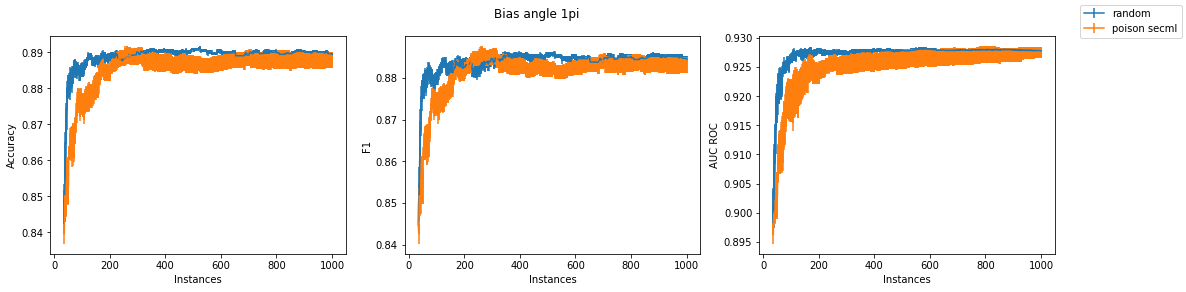

In [17]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

query_methods = {
    "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
    "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0)),
}

datasets = {
    "car": car
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.05)

    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=4 if name == "poison" or name == "inverted poison" else 10, desc=f"Run", leave=False)(
            delayed(
                lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner().active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, Y_test, method, stopping_func)
            )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
            for _ in range(4 if name == "poison" or name == "inverted poison" else 10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv")
        stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"{dataset_name}")
                
    fig.legend()

In [69]:
from collections import Counter

In [70]:
Counter(car()[1])

Counter({'unacc': 1210, 'acc': 384, 'vgood': 65, 'good': 69})

In [ ]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

import libadversarial; reload(libadversarial); from libadversarial import poison_secml

datasets = {
    "car": car
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    
    query_methods = {
        #"random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0)),
    }
    
    # Reduce to binary classification (Haven't figured out if secml can handle non-binary)
    filter_ = np.logical_or(y == 'unacc', y == 'acc')
    X, y = X[filter_], y[filter_]
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.05, shuffle=True)

    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                lambda X_labelled, y_labelled, oracle, X_test, y_test, method: MyActiveLearner().active_learn_query_synthesis(X_labelled, y_labelled, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func)
            )(X_labelled, y_labelled, oracle, X_test, y_test, method)
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv")
        stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"{dataset_name}")
                
    fig.legend()

In [ ]:
poison_metrics = metrics
poison_stderr = stderr